In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.fx
from torch.fx.node import Node
from torchmetrics import Accuracy

from typing import Dict


import sys
sys.path.append('..')

from fast_nas_adapt.src.resnet18 import ResNet18
from fast_nas_adapt.src.module2graph import GraphInterperterWithGamma

In [2]:
class GraphInterperterWithGumbelSoftmaxGamma(GraphInterperterWithGamma):
    def __init__(self, mod, /, *, gamma_shift=0.0, temperature=1.0):
        self.gamma_shift = gamma_shift
        self.temperature = temperature
        super().__init__(mod)

    def init_gammas(self):
        i = 0
        gammas = []
        self.gammas_name = {}
        for node in self.graph.nodes:
            if node.op == 'call_module':
                gammas.append(np.random.randn()+self.gamma_shift)
                self.gammas_name[str(node)] = i# перевод в str тут для удобства. в реалньых методах это не нужно
                i+=1                        # да и вообще, тут по идее должен быть тензор/параметр
        self.gammas =  torch.nn.Parameter(torch.as_tensor(gammas), requires_grad = True)
        self.discrete = False 

    def sample_gammas(self):
        if self.discrete:
            return self.gammas
        else:
            d = torch.distributions.RelaxedBernoulli(logits=self.gammas, temperature=self.temperature)
            return d.rsample()
        
    def make_gammas_discrete(self):
        self.gammas.data = (self.gammas.data>=0) * 1.0
        self.gammas.requires_grad = False 
        self.discrete = True

In [3]:
model = ResNet18(num_classes=10)

model_path = '../fast_nas_adapt/cv_experiment/results/aggressive/model_8.ckpt'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

Using cache found in /Users/b1/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/b1/Library/Python/3.8/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/b1/Library/Python/3.8/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [4]:
from fast_nas_adapt.src.cifar_data import get_dataloaders

train_dl, test_dl = get_dataloaders(classes=range(10), batch_size=64, img_size=33)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
for param in model.parameters():
    param.requires_grad = False

loss_fn = torch.nn.CrossEntropyLoss()

times = pd.read_csv("ResNet18HomeMeasurments.csv", index_col=0)
times = torch.tensor(times['mean'], dtype=torch.float32)

In [6]:
metric = Accuracy(task="multiclass", num_classes=10)

loss = []
accs = []

for i, (X, y) in tqdm(enumerate(test_dl), 'validating', total=len(test_dl)):
    if X.shape[0] != 64:
        continue

    logits = model(X)[0].detach()
    loss.append(loss_fn(logits, y))
    metric(logits.argmax(-1), y)

    if i == 10:
        break

np.mean(loss), metric.compute().item()

validating:   6%|█▉                            | 10/157 [00:02<00:32,  4.59it/s]


(1.5087593, 0.5383522510528564)

In [7]:
def train_epoch(m, /, *, lambd):
    optimizer = torch.optim.Adam([m.gammas])
    
    for i, (X, y) in tqdm(enumerate(train_dl), 'training', total=len(train_dl)):
        optimizer.zero_grad()
        y_pred = m(X)
        loss = loss_fn(y_pred, y) + lambd * m.gammas.dot(times)
        loss.backward(retain_graph=True)
        optimizer.step()

        if i == 10:
            break

def validate(m):
    metric = Accuracy(task="multiclass", num_classes=10)
    
    loss = []
    
    for i, (X, y) in tqdm(enumerate(test_dl), 'validating', total=len(test_dl)):
        if X.shape[0] != 64:
            continue

        logits = m(X).detach()
        loss.append(loss_fn(logits, y))
        metric(logits.argmax(-1), y)

        if i == 10:
            break

    return np.mean(loss), metric.compute().item()

validating:   6%|█▉                            | 10/157 [00:02<00:34,  4.22it/s]


0 5.335446 0.17329545319080353


validating:   6%|█▉                            | 10/157 [00:02<00:34,  4.26it/s]


1 2.3067477 0.09943182021379471


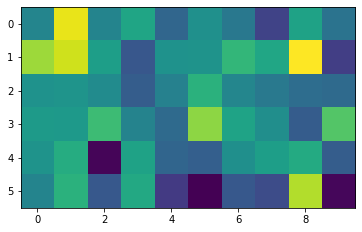

In [8]:
epoches = 1

for lambd in [0, 1]:
    imodel = GraphInterperterWithGumbelSoftmaxGamma(model.eval())

    imodel.train()
    for epoch in range(epoches):
        train_epoch(imodel, lambd=lambd)
    imodel.eval()

    plt.imshow(imodel.gammas.detach().reshape(-1, 10))
    imodel.make_gammas_discrete()

    loss, accuracy = validate(imodel)
    
    print(lambd, loss, accuracy)